In [1]:
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

train_path = 'C:/Users/zhang/mine/finTech/data/A/训练数据集'
test_path = 'C:/Users/zhang/mine/finTech/data/A/评分数据集'

train_tag_DF = pd.read_csv(train_path + '/训练数据集_tag.csv')
train_trd_DF = pd.read_csv(train_path + '/训练数据集_trd.csv')
train_beh_DF = pd.read_csv(train_path + '/训练数据集_beh.csv')

# 0: 违约
# 1: 诚信

In [2]:
train_tag_DF.drop(['edu_deg_cd', 'deg_cd', 'atdd_type'], axis = 1, inplace = True)
train_tag_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39923 entries, 0 to 39922
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               39923 non-null  object
 1   flag                             39923 non-null  int64 
 2   gdr_cd                           39923 non-null  object
 3   age                              39923 non-null  int64 
 4   mrg_situ_cd                      39923 non-null  object
 5   acdm_deg_cd                      39922 non-null  object
 6   job_year                         39923 non-null  object
 7   ic_ind                           39923 non-null  object
 8   fr_or_sh_ind                     39923 non-null  object
 9   dnl_mbl_bnk_ind                  39923 non-null  object
 10  dnl_bind_cmb_lif_ind             39923 non-null  object
 11  hav_car_grp_ind                  39923 non-null  object
 12  hav_hou_grp_ind                 

In [ ]:
'''
for col in colname[1:]:
    print('col: ')
    print(train_tag_DF[col].value_counts().index.tolist())
'''

In [3]:
train_tag_DF.loc[train_tag_DF['cur_debit_min_opn_dt_cnt'] == -1, 'cur_debit_min_opn_dt_cnt'] = 0
train_tag_DF.loc[train_tag_DF['cur_credit_min_opn_dt_cnt'] == -1, 'cur_debit_min_opn_dt_cnt'] = 0    
train_tag_DF.loc[train_tag_DF['job_year'] == '\\N', 'job_year'] = '0'

strColName = ['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd']
colname = train_tag_DF.columns.values.tolist()
for col in colname[1:]:
    if col in strColName:
        train_tag_DF[col] = train_tag_DF[col].fillna('Unknown1')
        train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = 'Unknown2'
        train_tag_DF.loc[train_tag_DF[col] == '~', col] = 'Unknown3'
    if (not np.issubdtype(train_tag_DF[col], np.int64)) and col.split('_')[-1] == 'ind':
        train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '2'
    if (not np.issubdtype(train_tag_DF[col], np.int64)) and (col.split('_')[-1] in ['cnt', 'tms', 'day']):
        train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = np.nan
        train_tag_DF[col] = train_tag_DF[col].astype(np.float64)
        train_tag_DF[col] = train_tag_DF[col].fillna(0) # train_tag_DF[col].mean()
    if (not np.issubdtype(train_tag_DF[col], np.int64)) and (col.split('_')[-1] == 'cd'):
        if ('0' in train_tag_DF[col].value_counts().index.tolist()) and ('-1' in train_tag_DF[col].value_counts().index.tolist()):
            train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '-2'
        elif ('0' in train_tag_DF[col].value_counts().index.tolist()):
            train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '-1'
        else:
            train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '0'
            
for col in colname[1:]:
    if (not np.issubdtype(train_tag_DF[col], np.int64)) and (col not in strColName):
        train_tag_DF[col] = train_tag_DF[col].astype(np.int64)

In [4]:
train_tag_DF.fr_or_sh_ind.value_counts()

0    34251
1     5179
2      493
Name: fr_or_sh_ind, dtype: int64

In [ ]:
train_tag_DF['I12_mon_whl_tms'] = train_tag_DF[['l12mon_buy_fin_mng_whl_tms',
                                                'l12_mon_fnd_buy_whl_tms',
                                                'l12_mon_insu_buy_whl_tms',
                                                'l12_mon_gld_buy_whl_tms']].apply(lambda x: x.fillna(0).astype(np.int).sum(), axis = 1).astype(np.int64)
# 理财产品、基金、保险、黄金购买次数总和

train_tag_DF['ic_fr_sh_ind'] = train_tag_DF[['ic_ind', 'fr_or_sh_ind']].apply(lambda x: 4 if ((x[0] == 1) & (x[1] == 1)) else (3 if (x[1] == 1) else (2 if (x[0] == 1) else (1 if ((x[0] == 0) & (x[1] == 0)) else 0))), axis = 1)
# 0: no, 1: ic, 2: fr or sh, 3: both

train_tag_DF['hav_car_hou_ind'] = train_tag_DF[['hav_car_grp_ind',
                                                'hav_hou_grp_ind']].apply(lambda x: 4 if ((x[0] == 1) & (x[1] == 1)) else (3 if (x[1] == 1) else (2 if (x[0] == 1) else (1 if ((x[0] == 0) & (x[1] == 0)) else 0))), axis = 1)
# 0: no, 1: Car, 2: House, 3: both

#train_tag_DF['cur_credit_card'] = train_tag_DF[[ 'cur_credit_cnt', 'cur_credit_min_opn_dt_cnt', 'crd_card_act_ind']].apply(lambda x: x[0] * x[1] * (x[2] + 0.1), axis = 1)
# 信用卡张数、持有天数、活跃标志合并

In [ ]:
train_tag_DF.drop(['l12mon_buy_fin_mng_whl_tms', 'l12_mon_fnd_buy_whl_tms', 'l12_mon_insu_buy_whl_tms',
                   'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind',
                   #'l12_mon_gld_buy_whl_tms',  'cur_debit_cnt', 'cur_debit_min_opn_dt_cnt', 'frs_agn_dt_cnt', 
                  #'cur_credit_cnt', 'cur_credit_min_opn_dt_cnt', 'crd_card_act_ind',
                  #'hav_car_grp_ind', 'hav_hou_grp_ind', 'ic_ind', 'fr_or_sh_ind',
                  ],
                  axis = 1, inplace = True)
train_tag_DF.info()

In [ ]:
tag_id_list = train_tag_DF.id.unique().tolist()
trd_id_list = train_trd_DF.id.unique().tolist()
beh_id_list = train_beh_DF.id.unique().tolist()

print('tag id个数: ', len(tag_id_list))
print('trd id个数: ', len(trd_id_list))
print('beh id个数: ', len(beh_id_list))

print('trd shape: {}, beh shape: {}'.format(train_trd_DF.shape[0], train_beh_DF.shape[0]))
print('trd里的id是否在tag用户标签: ', np.sum(train_trd_DF.id.isin(train_tag_DF.id)))
print('beh里的id是否在tag用户标签', np.sum(train_beh_DF.id.isin(train_tag_DF.id)))

# 跟trx表合并

In [4]:
id_pay = train_trd_DF.groupby(['id', 'Dat_Flg1_Cd'])['cny_trx_amt'].sum().reset_index()

id_income = id_pay[id_pay['Dat_Flg1_Cd'] == 'C']
id_pay = id_pay[id_pay['Dat_Flg1_Cd'] == 'B']

id_income.reset_index(drop = True, inplace = True)
id_pay.reset_index(drop = True, inplace = True)

id_income.drop(['Dat_Flg1_Cd'], axis = 1, inplace = True)
id_pay.drop(['Dat_Flg1_Cd'], axis = 1, inplace = True)

id_income.rename(columns = {'cny_trx_amt': 'cny_trx_income'}, inplace = True)
id_pay.rename(columns = {'cny_trx_amt': 'cny_trx_pay'}, inplace = True)

id_income['cny_trx_income'] = id_income['cny_trx_income'].abs()
id_pay['cny_trx_pay'] = id_pay['cny_trx_pay'].abs()

print(id_income.shape)
print(id_pay.shape)

train_DF = pd.merge(train_tag_DF, id_income, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, id_pay, on = 'id', how = 'left')

train_DF['cny_trx_income'] = train_DF['cny_trx_income'].fillna(0)
train_DF['cny_trx_pay'] = train_DF['cny_trx_pay'].fillna(0)
# train_DF['actual_income'] = train_DF[['cny_trx_income', 'cny_trx_pay']].apply(lambda x: x[0] - x[1], axis = 1)

train_DF.head()

(30102, 2)
(29193, 2)


,id,flag,gdr_cd,age,mrg_situ_cd,acdm_deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,hav_hou_grp_ind,l6mon_agn_ind,frs_agn_dt_cnt,vld_rsk_ases_ind,fin_rsk_ases_grd_cd,confirm_rsk_ases_lvl_typ_cd,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,tot_ast_lvl_cd,pot_ast_lvl_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,l12_mon_gld_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,ovd_30d_loan_tot_cnt,his_lng_ovd_day,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,cny_trx_income,cny_trx_pay
0,U7A4BAD,0,M,41,B,Z,3,0,0,0,1,0,0,0,-1,0,-1,4,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,3,1,0,0,-1,10,17400.00,15000.00
1,U557810,0,M,35,A,G,4,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,-1,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,0,-1,10,0.00,0.00
2,U1E9240,0,M,53,B,C,9,0,0,1,1,0,0,1,935,1,3,3,6,7,-1,2,8,6,0,0,0,0,0,0,0,-1,0,0,7,2,0,0,-1,40,105718.04,131158.00
3,U6DED00,0,F,41,B,Z,0,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,0,-1,10,0.00,0.00
4,UDA8E28,0,F,42,B,Z,3,1,1,1,0,0,1,0,-1,0,-1,-1,1,5,-1,3,0,0,0,0,0,1,6,0,4,-1,0,0,2,7,0,0,-1,20,79505.55,70416.04


# 结合app行为表beh

In [5]:
id_beh = train_beh_DF.groupby(['id', 'page_no']).count()
id_beh.drop(['Unnamed: 3', 'page_tm'], axis = 1, inplace = True)
id_beh.rename(columns = {'flag': 'page_tms'}, inplace = True)
id_beh = id_beh.reset_index()
id_beh.sort_values(['id', 'page_tms'], inplace = True)

id_beh_class_count = id_beh.groupby(['id']).count()
id_beh_class_count = id_beh_class_count.reset_index()
id_beh_class_count.head(10)

id_beh_class_count.drop(['page_tms'], axis = 1, inplace = True)
id_beh_class_count.rename(columns = {'page_no': 'page_type_count'}, inplace = True)
id_beh_class_count.head(10)

id_beh.drop_duplicates('id', keep = 'last', inplace = True)
id_beh.drop(['page_tms'], axis = 1, inplace = True)
id_beh.rename(columns = {'page_no': 'most_tms_page_no'}, inplace = True)

beh_count = train_beh_DF.groupby(['id']).count()
beh_count.drop(['page_no', 'Unnamed: 3', 'page_tm'], axis = 1, inplace = True)
beh_count.rename(columns = {'flag': 'total_page_no_tms'}, inplace = True)
beh_count = beh_count.reset_index()

train_DF = pd.merge(train_DF, id_beh_class_count, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, id_beh, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, beh_count, on = 'id', how = 'left')
train_DF.head()

,id,flag,gdr_cd,age,mrg_situ_cd,acdm_deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,hav_hou_grp_ind,l6mon_agn_ind,frs_agn_dt_cnt,vld_rsk_ases_ind,fin_rsk_ases_grd_cd,confirm_rsk_ases_lvl_typ_cd,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,tot_ast_lvl_cd,pot_ast_lvl_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,l12_mon_gld_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,ovd_30d_loan_tot_cnt,his_lng_ovd_day,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,cny_trx_income,cny_trx_pay,page_type_count,most_tms_page_no,total_page_no_tms
0,U7A4BAD,0,M,41,B,Z,3,0,0,0,1,0,0,0,-1,0,-1,4,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,3,1,0,0,-1,10,17400.00,15000.00,NaN,NaN,NaN
1,U557810,0,M,35,A,G,4,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,-1,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,0,-1,10,0.00,0.00,NaN,NaN,NaN
2,U1E9240,0,M,53,B,C,9,0,0,1,1,0,0,1,935,1,3,3,6,7,-1,2,8,6,0,0,0,0,0,0,0,-1,0,0,7,2,0,0,-1,40,105718.04,131158.00,6.0,CQA,35.0
3,U6DED00,0,F,41,B,Z,0,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,0,-1,10,0.00,0.00,NaN,NaN,NaN
4,UDA8E28,0,F,42,B,Z,3,1,1,1,0,0,1,0,-1,0,-1,-1,1,5,-1,3,0,0,0,0,0,1,6,0,4,-1,0,0,2,7,0,0,-1,20,79505.55,70416.04,7.0,CQA,22.0


In [6]:
train_DF[['total_page_no_tms', 'page_type_count']] = train_DF[['total_page_no_tms', 'page_type_count']].fillna(0)
train_DF[['total_page_no_tms', 'page_type_count']] = train_DF[['total_page_no_tms', 'page_type_count']].astype(np.int64)

train_DF['most_tms_page_no'] = train_DF['most_tms_page_no'].fillna('Undo')
train_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39923 entries, 0 to 39922
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               39923 non-null  object 
 1   flag                             39923 non-null  int64  
 2   gdr_cd                           39923 non-null  object 
 3   age                              39923 non-null  int64  
 4   mrg_situ_cd                      39923 non-null  object 
 5   acdm_deg_cd                      39923 non-null  object 
 6   job_year                         39923 non-null  int64  
 7   ic_ind                           39923 non-null  int64  
 8   fr_or_sh_ind                     39923 non-null  int64  
 9   dnl_mbl_bnk_ind                  39923 non-null  int64  
 10  dnl_bind_cmb_lif_ind             39923 non-null  int64  
 11  hav_car_grp_ind                  39923 non-null  int64  
 12  hav_hou_grp_ind   

# 尝试预测

In [7]:
#train_DF_weneed = train_DF.drop(['id', 'cny_trx_pay', 'cny_trx_income'], axis = 1)
train_DF_weneed = train_DF.drop(['id', 'page_type_count'], axis = 1)
#train_DF_weneed = train_DF.drop(['id'], axis = 1)
train_DF_weneed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39923 entries, 0 to 39922
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   flag                             39923 non-null  int64  
 1   gdr_cd                           39923 non-null  object 
 2   age                              39923 non-null  int64  
 3   mrg_situ_cd                      39923 non-null  object 
 4   acdm_deg_cd                      39923 non-null  object 
 5   job_year                         39923 non-null  int64  
 6   ic_ind                           39923 non-null  int64  
 7   fr_or_sh_ind                     39923 non-null  int64  
 8   dnl_mbl_bnk_ind                  39923 non-null  int64  
 9   dnl_bind_cmb_lif_ind             39923 non-null  int64  
 10  hav_car_grp_ind                  39923 non-null  int64  
 11  hav_hou_grp_ind                  39923 non-null  int64  
 12  l6mon_agn_ind     

In [8]:
if (not np.issubdtype(train_DF_weneed.iloc[:, -2], np.int64)) and (not np.issubdtype(train_DF_weneed.iloc[:, -2], np.float64)):
    strCol2 = strColName + [train_DF_weneed.columns.values.tolist()[-2]]
elif (not np.issubdtype(train_DF_weneed.iloc[:, -1], np.int64)) and (not np.issubdtype(train_DF_weneed.iloc[:, -1], np.float64)):
    strCol2 = strColName + [train_DF_weneed.columns.values.tolist()[-1]]
else:
    strCol2 = strColName.copy()

strCol2

['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd', 'most_tms_page_no']

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoderLabel = LabelEncoder()

for sC in strCol2:
    train_DF_weneed[sC] = encoderLabel.fit_transform(train_DF_weneed[sC])

train_DF_weneed.head()

,flag,gdr_cd,age,mrg_situ_cd,acdm_deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,hav_hou_grp_ind,l6mon_agn_ind,frs_agn_dt_cnt,vld_rsk_ases_ind,fin_rsk_ases_grd_cd,confirm_rsk_ases_lvl_typ_cd,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,tot_ast_lvl_cd,pot_ast_lvl_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,l12_mon_gld_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,ovd_30d_loan_tot_cnt,his_lng_ovd_day,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,cny_trx_income,cny_trx_pay,most_tms_page_no,total_page_no_tms
0,0,1,41,1,8,3,0,0,0,1,0,0,0,-1,0,-1,4,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,3,1,0,0,-1,10,17400.00,15000.00,22,0
1,0,1,35,0,5,4,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,-1,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,0,-1,10,0.00,0.00,22,0
2,0,1,53,1,2,9,0,0,1,1,0,0,1,935,1,3,3,6,7,-1,2,8,6,0,0,0,0,0,0,0,-1,0,0,7,2,0,0,-1,40,105718.04,131158.00,2,35
3,0,0,41,1,8,0,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,0,-1,10,0.00,0.00,22,0
4,0,0,42,1,8,3,1,1,1,0,0,1,0,-1,0,-1,-1,1,5,-1,3,0,0,0,0,0,1,6,0,4,-1,0,0,2,7,0,0,-1,20,79505.55,70416.04,2,22


In [ ]:
# 从数据初探可以发现，'未来两年可能违约'标签类别分布不均，需对样本进行重取样
def resample(df):
    '''
    使样本'未来两年可能违约'标签的0，1项可以各占一半，以提高预测效果。sample()可以考虑添加random_state以便生成相同样本集
    df：数据源
    '''
    num = df['flag'].value_counts()[1]
    df_t = df[df.flag == 1]
    df_f = df[df.flag == 0].sample(frac=1)[0:num]
    df_balanced = pd.concat([df_t,df_f]).sample(frac=1).reset_index(drop=True)
#     print(df_balanced.未来两年可能违约.value_counts())
    return df_balanced

df_balanced = resample(train_DF_weneed)
df_balanced['flag'].value_counts()

# 预测部分

In [10]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
from sklearn.model_selection import KFold,train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def perfomance_clf(model,X,y,name=None):
    y_predict = model.predict(X)
    y_predict_prob = model.predict_proba(X)[:, 1]
    if name:
        print(name,':')
    print(f'accuracy score is: {accuracy_score(y,y_predict)}')
    print(f'precision score is: {precision_score(y,y_predict)}')
    print(f'recall score is: {recall_score(y,y_predict)}')
    print(f'auc: {roc_auc_score(y,y_predict_prob)}')
    print('- - - - - - ')
    
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr)#, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()    

## 原始预测

In [11]:
df_x = train_DF_weneed.drop(['flag'], axis = 1)
df_y = train_DF_weneed['flag']
#xtrain, xtest, ytrain, ytest = train_test_split(df_x, df_y, test_size=0.2)    # random_state=42
trainx, valx, trainy, valy = train_test_split(df_x, df_y, test_size=.2, random_state=2020)

# 分层k折交叉拆分器 - 用于网格搜索
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [ ]:
for col in colname[1:]:
    if col.split('_')[-1] == 'cd':
        print(col, ': ')
        print(train_DF[col].value_counts().index.tolist)
        

roc  0.7425465811632959
accuracy score is: 0.808140262993112
precision score is: 0.6565809379727685
recall score is: 0.24956871765382405
auc: 0.7425465811632959
- - - - - - 


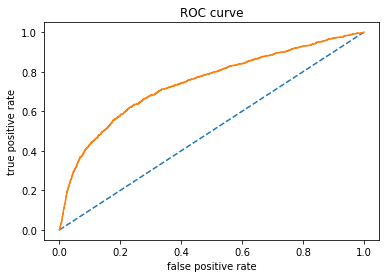

In [12]:
####### 不加变量不删变量，合并trx、beh（最高访问名字，访问次数）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.7378748851248699
accuracy score is: 0.7929868503443958
precision score is: 0.5272151898734178
recall score is: 0.47901092581943644
auc: 0.7378748851248699
- - - - - - 


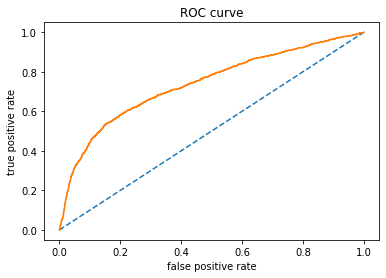

In [14]:
############ 随机森林
model = RandomForestClassifier(n_estimators = 200,
                               class_weight = 'balanced',
                               min_samples_split = 5,
                               min_samples_leaf = 4,
                               max_features = 3)
##(n_estimators=220, class_weight = 'balanced').fit(trainx, trainy)
# {0: 1, 1:3}
model.fit(trainx, trainy)
predictionforest = model.predict_proba(valx)[:, 1]

rocrf=roc_auc_score(valy, predictionforest)
print('roc ',rocrf)
perfomance_clf(model, valx, valy)
plot_roc(valy, predictionforest)

roc  0.743228052382507
accuracy score is: 0.8086412022542266
precision score is: 0.6500711237553343
recall score is: 0.26279470960322027
auc: 0.743228052382507
- - - - - - 


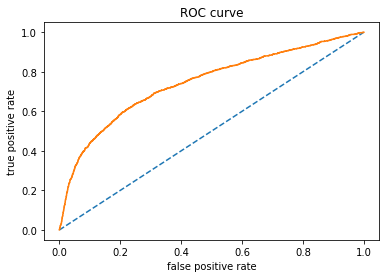

In [15]:
####### 不加变量不删变量，合并trx、beh（最高访问名字，访问次数）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 100,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.7277904552415558
accuracy score is: 0.7993738259236067
precision score is: 0.6479481641468683
recall score is: 0.1725129384703853
auc: 0.7277904552415558
- - - - - - 


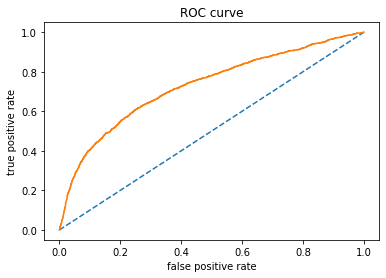

In [16]:
from sklearn.ensemble import AdaBoostClassifier
ada_cfl = AdaBoostClassifier(n_estimators = 200)
ada_cfl.fit(trainx, trainy)

y_score = ada_cfl.predict_proba(valx)[:,1]
rocada = roc_auc_score(valy, y_score)
print('roc ',rocada)
perfomance_clf(ada_cfl, valx, valy)
plot_roc(valy, y_score)
# roc: 0.7270584398857132

roc  0.7263509140386939
accuracy score is: 0.7983719474013776
precision score is: 0.6405228758169934
recall score is: 0.16906267970097758
auc: 0.7263509140386939
- - - - - - 


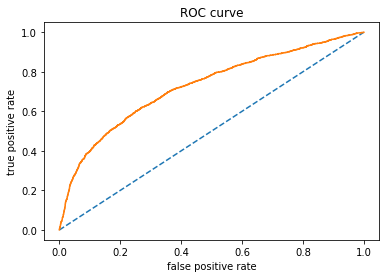

In [17]:
from sklearn.ensemble import AdaBoostClassifier
ada_cfl = AdaBoostClassifier(n_estimators = 100)
ada_cfl.fit(trainx, trainy)

y_score = ada_cfl.predict_proba(valx)[:,1]
rocada = roc_auc_score(valy, y_score)
print('roc ',rocada)
perfomance_clf(ada_cfl, valx, valy)
plot_roc(valy, y_score)
# roc: 0.7257069136092987

roc  0.7435025005998088
accuracy score is: 0.8118973074514715
precision score is: 0.6565389696169088
recall score is: 0.28579643473260496
auc: 0.7435025005998088
- - - - - - 


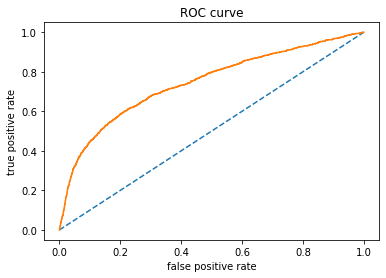

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
GBDT = GradientBoostingClassifier(n_estimators=110,min_samples_split=12,min_samples_leaf=6,max_depth=6)
GBDT.fit(trainx, trainy)
#
y_score = GBDT.predict_proba(valx)[:,1]
rocada = roc_auc_score(valy, y_score)
print('roc ',rocada)
perfomance_clf(GBDT, valx, valy)
plot_roc(valy, y_score)
# auc: 0.7420885076627306

accuracy score is: 0.782592360676268
precision score is: 1.0
recall score is: 0.0017251293847038527
auc: 0.5543393660384279
- - - - - - 
roc  0.5543393660384279


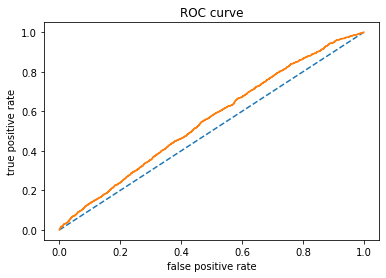

In [16]:
############## logistic
def logistic(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2020)
    lr = LogisticRegression()
    lr.fit(X_train,y_train)
    prob = lr.predict_proba(X_test)
    
    perfomance_clf(lr, X_test, y_test)
    roc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    print('roc ',roc)

    return (prob[:,1],y_test)

probs, y_test=logistic(df_x, df_y)
plot_roc(y_test,probs)

# Search

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.4min finished


The best parameters:  {'C': 1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1'}
roc  0.6626329867791637
accuracy score is: 0.6646211646837821
precision score is: 0.3306887847097007
recall score is: 0.5273145485911443
auc: 0.6626329867791637
- - - - - - 


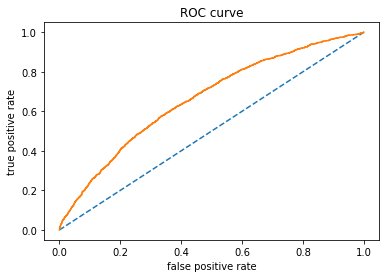

In [15]:
############# logistic
# search
log_cfl = LogisticRegression()

param_grid = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', {0: 1, 1: 3}], 
            'C' : [0.1, 1, 10, 100, 1000]
            }

CV_log_cfl = GridSearchCV(estimator = log_cfl, param_grid = param_grid , cv = cv, scoring = 'roc_auc', verbose = 1, n_jobs = -1)
CV_log_cfl.fit(trainx, trainy)

best_parameters = CV_log_cfl.best_params_
print("The best parameters: ", best_parameters)

# 回归
log_cfl = LogisticRegression(C = best_parameters['C'], 
                             penalty = best_parameters['penalty'], 
                             class_weight = best_parameters['class_weight'])

log_cfl.fit(trainx, trainy)
#y_scoreLR = log_cfl.decision_function(valx)
y_scoreLR = log_cfl.predict_proba(valx)[:, 1]

rocLR=roc_auc_score(valy, y_scoreLR)
print('roc ',rocLR)
perfomance_clf(log_cfl, valx, valy)
plot_roc(valy, y_scoreLR)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  9

The best parameters:  {'class_weight': {0: 1, 1: 3}, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
roc  0.7374945612115273
accuracy score is: 0.7986224170319349
precision score is: 0.5459004905395936
recall score is: 0.4479585968947671
auc: 0.7374945612115273
- - - - - - 


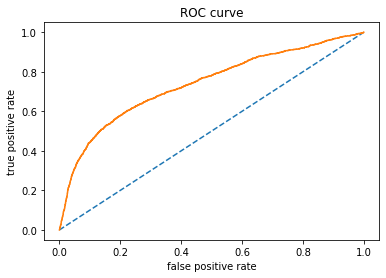

In [19]:
################### 随机森林
# search
rf_cfl = RandomForestClassifier(n_estimators=120).fit(trainx, trainy)

param_grid = {
            'n_estimators': [50, 100, 200],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'class_weight' :  ['balanced', {0: 1, 1: 3}],
            }

CV_rnd_cfl = GridSearchCV(estimator = rf_cfl, param_grid = param_grid, cv = cv, scoring = 'roc_auc', verbose = 10, n_jobs = -1)
CV_rnd_cfl.fit(trainx, trainy)

best_parameters = CV_rnd_cfl.best_params_
print("The best parameters: ", best_parameters)
# The best parameters:  {'class_weight': {0: 1, 1: 3}, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
# auc: 0.7374945612115273
####### 预测
rf_cfl = RandomForestClassifier(n_estimators = best_parameters['n_estimators'],
                                max_features = best_parameters['max_features'], 
                                min_samples_leaf = best_parameters['min_samples_leaf'],  
                                class_weight = best_parameters['class_weight'],
                                min_samples_split = 5)
rf_cfl.fit(trainx, trainy)
y_score = rf_cfl.predict_proba(valx)[:,1]

rocRF=roc_auc_score(valy, y_score)
print('roc ',rocRF)
perfomance_clf(rf_cfl, valx, valy)

plot_roc(valy, y_score)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] class_weight=balanced, n_estimators=50 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... class_weight=balanced, n_estimators=50, total=   8.9s
[CV] class_weight=balanced, n_estimators=50 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] ........... class_weight=balanced, n_estimators=50, total=   8.7s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   9.0s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   7.8s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   8.0s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   8.8s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   9.9s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   9.5s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] .

[CV] ...... class_weight={0: 1, 1: 3}, n_estimators=200, total=  29.0s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 19.0min finished


The best parameters:  {'class_weight': 'balanced', 'n_estimators': 50}
roc  0.7378206583553325
accuracy score is: 0.8103944896681278
precision score is: 0.6404494382022472
recall score is: 0.2949971247843588
auc: 0.7378206583553325
- - - - - - 


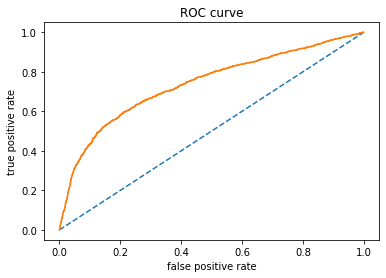

In [20]:
######################### XGBoost
# search
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)
xgb_cfl.fit(trainx, trainy)
y_pred = xgb_cfl.predict(valx)
y_score = xgb_cfl.predict_proba(valx)[:,1]

param_grid = {
            'n_estimators': [50, 100, 200],
            'class_weight' :  ['balanced', {0: 1, 1: 3}],
              }

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, cv = 10, scoring ='roc_auc', verbose = 2)
CV_xgb_cfl.fit(trainx, trainy)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters: ", best_parameters)

xgb_cfl2 = xgb.XGBClassifier(n_jobs = -1,
                             n_estimators = best_parameters['n_estimators'], 
                             class_weight = best_parameters['class_weight'])

xgb_cfl2.fit(trainx, trainy)

y_score2 = xgb_cfl2.predict_proba(valx)[:,1]
rocxgb=roc_auc_score(valy, y_score2)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl2, valx, valy)
plot_roc(valy, y_score2)

roc  0.7380404194739838
accuracy score is: 0.8071383844708829
precision score is: 0.6439942112879884
recall score is: 0.25589419206440484
auc: 0.7380404194739838
- - - - - - 


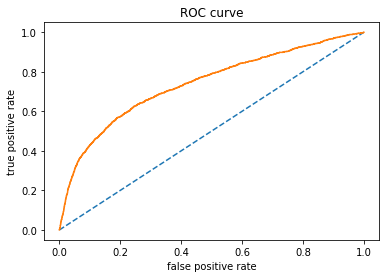

In [52]:
####### 
# 加:
# 理财产品、基金、保险、黄金购买次数总和
# 丢:
# 合并项
######### 合并trx、beh（最高访问名字，访问次数）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.7381969313724787
accuracy score is: 0.8068879148403256
precision score is: 0.6485671191553545
recall score is: 0.24726854514088556
auc: 0.7381969313724787
- - - - - - 


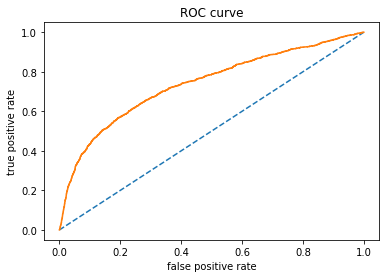

In [31]:
####### 
# 加:
# 理财产品、基金、保险、黄金购买次数总和
# 0: no, 1: ic, 2: fr or sh, 3: both
# 0: no, 1: Car, 2: House, 3: both
# 丢:
# 合并项
######### 合并trx、beh（最高访问名字，访问次数）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.740205899688394
accuracy score is: 0.8080150281778334
precision score is: 0.6537313432835821
recall score is: 0.2518688901667625
auc: 0.740205899688394
- - - - - - 


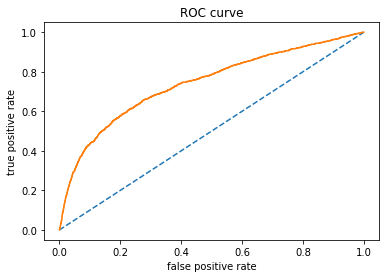

In [14]:
####### 
# 加:
# 理财产品、基金、保险、黄金购买次数总和
# 0: no, 1: ic, 2: fr or sh, 3: both
# 0: no, 1: Car, 2: House, 3: both
# 丢:
# 合并项，以及借记卡张数等
######### 合并trx、beh（最高访问名字，访问次数）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.7347013301854187
accuracy score is: 0.8068879148403256
precision score is: 0.6476761619190404
recall score is: 0.2484186313973548
auc: 0.7347013301854187
- - - - - - 


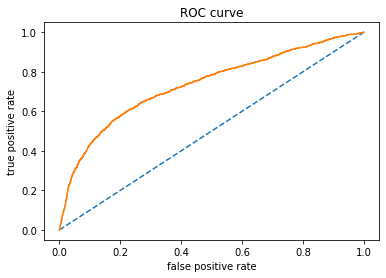

In [88]:
####### 
# 加:
# 理财产品、基金、保险、黄金购买次数总和
# 0: no, 1: ic, 2: fr or sh, 3: both
# 0: no, 1: Car, 2: House, 3: both
# 信用卡张数、持有天数、活跃标志合并
# 丢:
# 合并项，以及借记卡张数等
######### 合并trx、beh（最高访问名字，访问次数）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.7429729840208716
accuracy score is: 0.808891671884784
precision score is: 0.6606334841628959
recall score is: 0.2518688901667625
auc: 0.7429729840208716
- - - - - - 


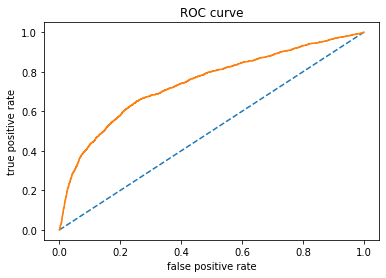

In [68]:
####### 不加变量不删变量，合并trx、beh（访问次数）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.7419766476882179
accuracy score is: 0.8080150281778334
precision score is: 0.6537313432835821
recall score is: 0.2518688901667625
auc: 0.7419766476882179
- - - - - - 


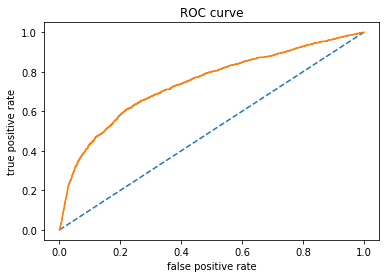

In [44]:
####### 不加变量不删变量，合并trx、beh（最高访问名字）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.743958962948478
accuracy score is: 0.8083907326236693
precision score is: 0.6557377049180327
recall score is: 0.25301897642323173
auc: 0.743958962948478
- - - - - - 


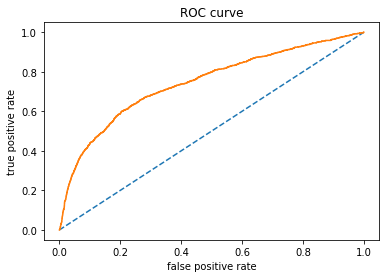

In [39]:
####### 不加变量不删变量，合并trx、beh（最高访问名字，访问次数）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.7433234786076774
accuracy score is: 0.8090169067000627
precision score is: 0.6597014925373135
recall score is: 0.25416906267970096
auc: 0.7433234786076774
- - - - - - 


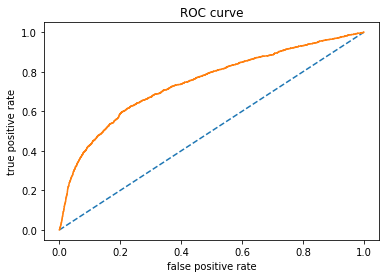

In [31]:
####### 不加变量不删变量，合并trx、beh（最高访问名字，访问次数，访问种类数）
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.7426606507175519
accuracy score is: 0.8078897933625548
precision score is: 0.6536731634182908
recall score is: 0.2507188039102933
auc: 0.7426606507175519
- - - - - - 


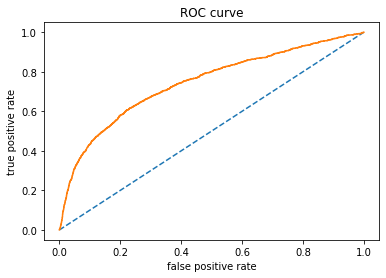

In [17]:
####### 不加变量不删变量，只合并trx
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

accuracy score is: 0.782216656230432
precision score is: 0.0
recall score is: 0.0
auc: 0.5352864821409796
- - - - - - 
roc  0.5352864821409796


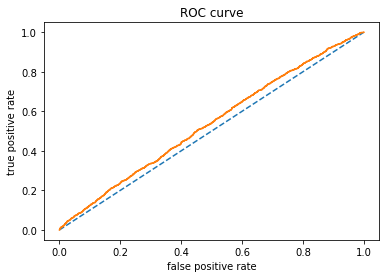

In [11]:
############## logistic
def logistic(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2020)
    lr = LogisticRegression()
    lr.fit(X_train,y_train)
    prob = lr.predict_proba(X_test)
    
    perfomance_clf(lr, X_test, y_test)
    roc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    print('roc ',roc)

    return (prob[:,1],y_test)

probs, y_test=logistic(df_x, df_y)
plot_roc(y_test,probs)

In [12]:
trainx, valx, trainy, valy = train_test_split(df_x, df_y, test_size=.2, random_state=2020)

roc  0.7207522072320648
accuracy score is: 0.8030056355666876
precision score is: 0.628482972136223
recall score is: 0.23346751006325475
auc: 0.7207522072320648
- - - - - - 


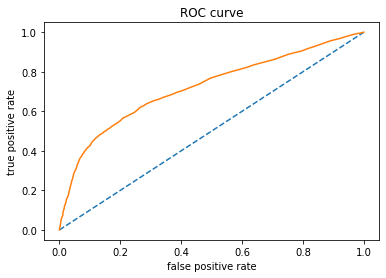

In [13]:
############ 随机森林
model = RandomForestClassifier(n_estimators=220, class_weight = 'balanced').fit(trainx, trainy)
# {0: 1, 1:3}
predictionforest = model.predict_proba(valx)[:, 1]

rocrf=roc_auc_score(valy, predictionforest)
print('roc ',rocrf)
perfomance_clf(model, valx, valy)
plot_roc(valy, predictionforest)

roc  0.6930245132618056
accuracy score is: 0.7887288666249217
precision score is: 0.5263157894736842
recall score is: 0.29902242668200113
auc: 0.6930245132618056
- - - - - - 


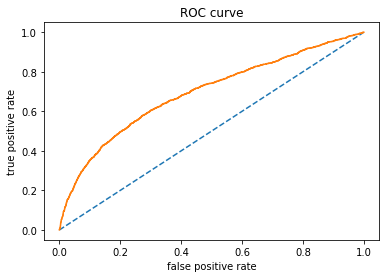

In [15]:
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

# Grid Search

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished


The best parameters:  {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1'}
roc  0.6493356898501298
accuracy score is: 0.653976205385097
precision score is: 0.3181818181818182
recall score is: 0.5152386428982174
auc: 0.6493356898501298
- - - - - - 


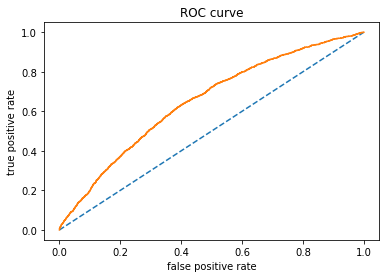

In [20]:
############# logistic
# search
log_cfl = LogisticRegression()

param_grid = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', {0: 1, 1: 3}], 
            'C' : [0.1, 1, 10, 100, 1000]
            }

CV_log_cfl = GridSearchCV(estimator = log_cfl, param_grid = param_grid , cv = cv, scoring = 'roc_auc', verbose = 1, n_jobs = -1)
CV_log_cfl.fit(trainx, trainy)

best_parameters = CV_log_cfl.best_params_
print("The best parameters: ", best_parameters)

# 回归
log_cfl = LogisticRegression(C = best_parameters['C'], 
                             penalty = best_parameters['penalty'], 
                             class_weight = best_parameters['class_weight'])

log_cfl.fit(trainx, trainy)
#y_scoreLR = log_cfl.decision_function(valx)
y_scoreLR = log_cfl.predict_proba(valx)[:, 1]

rocLR=roc_auc_score(valy, y_scoreLR)
print('roc ',rocLR)
perfomance_clf(log_cfl, valx, valy)
plot_roc(valy, y_scoreLR)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 12

The best parameters:  {'class_weight': {0: 1, 1: 3}, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
roc  0.7302368743137644
accuracy score is: 0.7993738259236067
precision score is: 0.5486160397444997
recall score is: 0.4445083381253594
auc: 0.7302368743137644
- - - - - - 


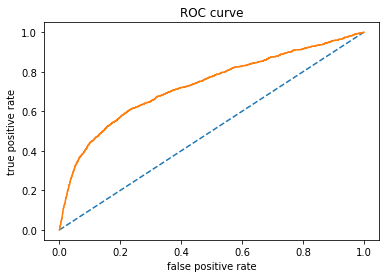

In [21]:
################### 随机森林
# search
rf_cfl = RandomForestClassifier(n_estimators=120).fit(trainx, trainy)

param_grid = {
            'n_estimators': [50, 100, 200],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'class_weight' :  ['balanced', {0: 1, 1: 3}],
            }

CV_rnd_cfl = GridSearchCV(estimator = rf_cfl, param_grid = param_grid, cv = cv, scoring = 'roc_auc', verbose = 10, n_jobs = -1)
CV_rnd_cfl.fit(trainx, trainy)

best_parameters = CV_rnd_cfl.best_params_
print("The best parameters: ", best_parameters)

####### 预测
rf_cfl = RandomForestClassifier(n_estimators = best_parameters['n_estimators'],
                                max_features = best_parameters['max_features'], 
                                min_samples_leaf = best_parameters['min_samples_leaf'],  
                                class_weight = best_parameters['class_weight'],
                                min_samples_split = 5)
rf_cfl.fit(trainx, trainy)
y_score = rf_cfl.predict_proba(valx)[:,1]

rocRF=roc_auc_score(valy, y_score)
print('roc ',rocRF)
perfomance_clf(rf_cfl, valx, valy)

plot_roc(valy, y_score)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] class_weight=balanced, n_estimators=50 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... class_weight=balanced, n_estimators=50, total=   9.5s
[CV] class_weight=balanced, n_estimators=50 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] ........... class_weight=balanced, n_estimators=50, total=   6.7s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   7.5s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   6.8s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   7.3s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   7.3s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   6.6s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] ........... class_weight=balanced, n_estimators=50, total=   6.3s
[CV] class_weight=balanced, n_estimators=50 ..........................
[CV] .

[CV] ...... class_weight={0: 1, 1: 3}, n_estimators=200, total=  20.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 18.9min finished


The best parameters:  {'class_weight': 'balanced', 'n_estimators': 50}
roc  0.7325747017481643
accuracy score is: 0.8090169067000627
precision score is: 0.63510101010101
recall score is: 0.28924669350201265
auc: 0.7325747017481643
- - - - - - 


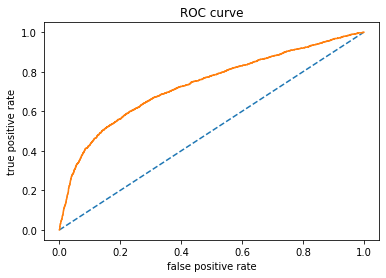

In [17]:
######################### XGBoost
# search
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)
xgb_cfl.fit(trainx, trainy)
y_pred = xgb_cfl.predict(valx)
y_score = xgb_cfl.predict_proba(valx)[:,1]

param_grid = {
            'n_estimators': [50, 100, 200],
            'class_weight' :  ['balanced', {0: 1, 1: 3}],
              }

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, cv = 10, scoring ='roc_auc', verbose = 2)
CV_xgb_cfl.fit(trainx, trainy)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters: ", best_parameters)

xgb_cfl2 = xgb.XGBClassifier(n_jobs = -1,
                             n_estimators = best_parameters['n_estimators'], 
                             class_weight = best_parameters['class_weight'])

xgb_cfl2.fit(trainx, trainy)

y_score2 = xgb_cfl2.predict_proba(valx)[:,1]
rocxgb=roc_auc_score(valy, y_score2)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl2, valx, valy)
plot_roc(valy, y_score2)